In [1]:
#Imports
import pandas as pd
import os
import glob
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"




First, we will analyze all of the data in the Disruptions folder. This will be done in the codeblock below



Successfully loaded and combined 14 files with a total of 55,864 disruptions.

--- Processed Disruptions Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55864 entries, 0 to 55863
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   rdt_id                55864 non-null  int64         
 1   ns_lines              55864 non-null  object        
 2   rdt_lines             54690 non-null  object        
 3   rdt_lines_id          54690 non-null  object        
 4   rdt_station_names     41162 non-null  object        
 5   rdt_station_codes     41162 non-null  object        
 6   cause_nl              55679 non-null  object        
 7   cause_en              55679 non-null  object        
 8   statistical_cause_nl  55679 non-null  object        
 9   statistical_cause_en  55679 non-null  object        
 10  cause_group           55862 non-null  object        
 11  start_time   

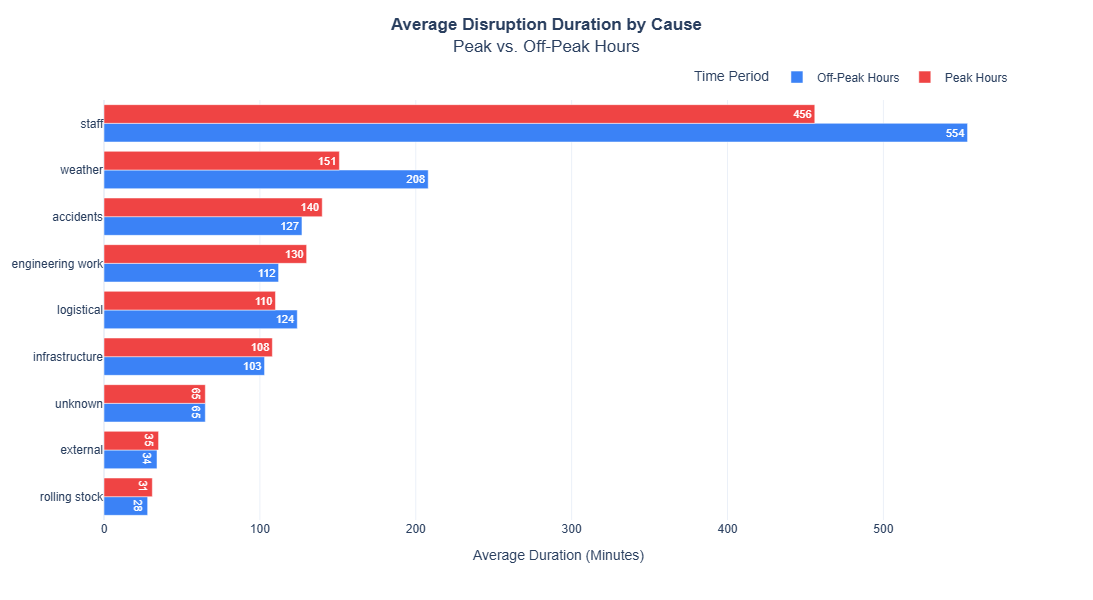

In [2]:
def process_disruptions_data(folder_path):
    """
    Loads, combines, and processes all disruption CSV files from a given folder.

    Args:
        folder_path (str): The path to the folder containing the disruption CSVs.

    Returns:
        pandas.DataFrame: A combined and processed DataFrame of all disruptions.
    """
    csv_files = glob.glob(os.path.join(folder_path, "disruptions-*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in '{folder_path}'. Please check the path.")
        return None

    df_list = [pd.read_csv(file) for file in csv_files]

    disruptions_df = pd.concat(df_list, ignore_index=True)
    print(f"Successfully loaded and combined {len(csv_files)} files with a total of {len(disruptions_df):,} disruptions.")

    
    disruptions_df['start_time'] = pd.to_datetime(disruptions_df['start_time'])
    disruptions_df['end_time'] = pd.to_datetime(disruptions_df['end_time'])

    disruptions_df['start_hour'] = disruptions_df['start_time'].dt.hour
    disruptions_df['day_of_week'] = disruptions_df['start_time'].dt.day_name()
    disruptions_df['month'] = disruptions_df['start_time'].dt.month
    disruptions_df['year'] = disruptions_df['start_time'].dt.year

    is_weekday = disruptions_df['start_time'].dt.weekday < 5  # Monday=0, Sunday=6
    is_morning_peak = (disruptions_df['start_hour'] >= 6) & (disruptions_df['start_hour'] < 9)
    is_evening_peak = (disruptions_df['start_hour'] >= 16) & (disruptions_df['start_hour'] < 19) # Note: 18:30 falls within hour 18

    disruptions_df['is_peak'] = (is_weekday & (is_morning_peak | is_evening_peak))

    major_hubs = ['Amsterdam', 'Utrecht', 'Rotterdam', 'Den Haag']
    hub_pattern = '|'.join(major_hubs)
    disruptions_df['affects_major_hub'] = (
        disruptions_df['ns_lines'].str.contains(hub_pattern, case=False, na=False) |
        disruptions_df['rdt_station_names'].str.contains(hub_pattern, case=False, na=False)
    )

    return disruptions_df
disruptions_folder = 'TIL Programming\Disruptions' 
disruptions_data = process_disruptions_data(disruptions_folder)

if disruptions_data is not None:
    print("\n--- Processed Disruptions Data Info ---")
    disruptions_data.info()
    
    print("\n--- Sample of Processed Data ---")
    print(disruptions_data[['start_time', 'start_hour', 'is_peak', 'affects_major_hub', 'cause_en', 'duration_minutes']].head())
    
    print("\n--- Disruptions by Peak vs. Off-Peak ---")
    print(disruptions_data['is_peak'].value_counts(normalize=True))
    
    print("\n--- Average Duration (minutes) by Cause and Peak Hour ---")
    avg_duration = disruptions_data.groupby(['cause_group', 'is_peak'])['duration_minutes'].median().unstack().fillna(0)
    print(avg_duration)

    avg_duration.rename(columns={True: 'Peak Hours', False: 'Off-Peak Hours'}, inplace=True)
    
    avg_duration.sort_values(by='Peak Hours', ascending=True, inplace=True)

    fig = go.Figure()
    fig.add_trace(go.Bar(
        y=avg_duration.index,
        x=avg_duration['Off-Peak Hours'],
        name='Off-Peak Hours',
        orientation='h',
        marker_color='rgb(59, 130, 246)', # Blue
        text=avg_duration['Off-Peak Hours'].round(1),
        textposition='inside'
    ))
    fig.add_trace(go.Bar(
        y=avg_duration.index,
        x=avg_duration['Peak Hours'],
        name='Peak Hours',
        orientation='h',
        marker_color='rgb(239, 68, 68)', # Red
        text=avg_duration['Peak Hours'].round(1),
        textposition='inside'
    ))
    fig.update_layout(
        barmode='group', # Group bars side-by-side
        title={
            'text': '<b>Average Disruption Duration by Cause</b><br>Peak vs. Off-Peak Hours',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Average Duration (Minutes)',
        yaxis_title=None, # Y-axis title is redundant here
        font_family="Arial",
        legend_title_text='Time Period',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=600 # Increase height to give labels more space
    )
    
    fig.update_traces(textfont_size=12, textfont_color='white')

    fig.show()



Next, we will analyze the daily checkins. 



Successfully loaded check-in data with 26,301 rows.

--- Processed Check-in Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26301 entries, 2020-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    26301 non-null  int64  
 1   month                   26301 non-null  int64  
 2   day                     26301 non-null  int64  
 3   hour                    26301 non-null  int64  
 4   check_ins               26301 non-null  float64
 5   ref_pre_covid           26301 non-null  float64
 6   ref_previous_year       26301 non-null  float64
 7   delta_vs_precovid       26301 non-null  float64
 8   delta_vs_previous_year  26301 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 2.0 MB

--- Sample of Processed Check-in Data ---
                     year  month  day  hour  check_ins  ref_pre_covid  \
datetime          

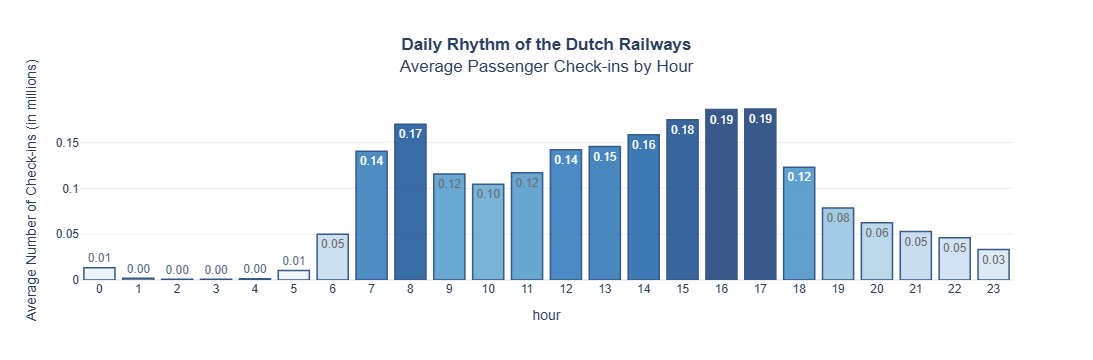

In [3]:
def process_checkin_data(file_path):
    """
    Loads and processes the hourly check-in data.

    Args:
        file_path (str): The path to the check-in CSV file.

    Returns:
        pandas.DataFrame: A processed DataFrame of check-in data.
    """
    if not os.path.exists(file_path):
        print(f"File not found: '{file_path}'. Please check the path.")
        return None
    
    checkin_df = pd.read_csv(file_path)
    print(f"Successfully loaded check-in data with {len(checkin_df):,} rows.")

    column_mapping = {
        'Jaar': 'year',
        'Maand': 'month',
        'Dag': 'day',
        'Uur': 'hour',
        'Aantal_check_ins': 'check_ins',
        'Referentie_pre_COVID_19': 'ref_pre_covid',
        'Referentie_vorig_jaar': 'ref_previous_year',
        'Delta_actueel_pre_COVID_19': 'delta_vs_precovid',
        'Delta_actueel_vorig_jaar': 'delta_vs_previous_year'
    }
    checkin_df.rename(columns=column_mapping, inplace=True)

    checkin_df['datetime'] = pd.to_datetime(checkin_df[['year', 'month', 'day', 'hour']])

    for col in ['delta_vs_precovid', 'delta_vs_previous_year']:
        checkin_df[col] = checkin_df[col].str.replace('%', '').astype(float) / 100.0

    checkin_df.set_index('datetime', inplace=True)

    return checkin_df

checkin_file = 'TIL Programming\Instappers_per_uur_export_tm_20221231.csv'
checkin_data = process_checkin_data(checkin_file)

if checkin_data is not None:
    print("\n--- Processed Check-in Data Info ---")
    checkin_data.info()
    
    print("\n--- Sample of Processed Check-in Data ---")
    print(checkin_data.head())
    
    print("\n--- Average Check-ins per Hour of the Day ---")
    avg_hourly_checkins = checkin_data.groupby('hour')['check_ins'].mean()
    print(avg_hourly_checkins)
    fig = px.bar(
        avg_hourly_checkins,
        x=avg_hourly_checkins.index,
        y=avg_hourly_checkins.values,
        labels={
            "x": "Hour of the Day",
            "y": "Average Number of Check-ins (in millions)"
        },
        title="<b>Daily Rhythm of the Dutch Railways</b><br>Average Passenger Check-ins by Hour",
        color=avg_hourly_checkins.values, # Color bars by their value
        color_continuous_scale=px.colors.sequential.Blues,
        text_auto='.2f' # Format text on bars to 2 decimal places
    )

    fig.update_layout(
        xaxis = dict(tickmode = 'linear', dtick = 1), # Show a tick for every hour
        font_family="Arial",
        title_x=0.5,
        coloraxis_showscale=False # Hide the color scale bar
    )
    fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.8)
    
    fig.show()
    